In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.svm import SVR

In [2]:
# read data
nifty50 =  pd.read_csv('nifty50_2015_20220410.csv')

In [3]:
nifty50.head()

Date      Open      High       Low     Close
0  10/03/22  17102.10  17114.65  16855.55  16887.35
1  09/30/22  16798.05  17187.10  16747.70  17094.35
2  09/29/22  16993.60  17026.05  16788.60  16818.10
3  09/28/22  16870.55  17037.60  16820.40  16858.60
4  09/27/22  17110.90  17176.45  16942.35  17007.40

In [4]:
# Checking for null values
nifty50.isnull().sum().any()

False

In [5]:
nifty50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1917 non-null   object 
 1    Open   1917 non-null   float64
 2    High   1917 non-null   float64
 3    Low    1917 non-null   float64
 4    Close  1917 non-null   float64
dtypes: float64(4), object(1)
memory usage: 75.0+ KB


In [6]:
# Rename columns as there is space
nifty50.rename(columns={"Date":"date"," Open":"open"," High":"high"," Low":"low"," Close":"close"}, inplace= True)
nifty50.head()

date      open      high       low     close
0  10/03/22  17102.10  17114.65  16855.55  16887.35
1  09/30/22  16798.05  17187.10  16747.70  17094.35
2  09/29/22  16993.60  17026.05  16788.60  16818.10
3  09/28/22  16870.55  17037.60  16820.40  16858.60
4  09/27/22  17110.90  17176.45  16942.35  17007.40

In [7]:
# Checking Data type of each column
print("Date column data type: ", type(nifty50['date'][0]))
print("Open column data type: ", type(nifty50['open'][0]))
print("Close column data type: ", type(nifty50['close'][0]))
print("High column data type: ", type(nifty50['high'][0]))
print("Low column data type: ", type(nifty50['low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>


In [8]:
# convert date field from string to Date format and make it index
nifty50['date'] = pd.to_datetime(nifty50.date)
nifty50.head()

date      open      high       low     close
0 2022-10-03  17102.10  17114.65  16855.55  16887.35
1 2022-09-30  16798.05  17187.10  16747.70  17094.35
2 2022-09-29  16993.60  17026.05  16788.60  16818.10
3 2022-09-28  16870.55  17037.60  16820.40  16858.60
4 2022-09-27  17110.90  17176.45  16942.35  17007.40

In [9]:
nifty50.shape

(1917, 5)

In [10]:
# Sort the data 
nifty50.sort_values(by='date', inplace=True)
nifty50.head()

date     open     high      low    close
1916 2015-01-01  8272.80  8294.70  8248.75  8272.80
1915 2015-01-02  8288.70  8410.60  8288.70  8288.70
1914 2015-01-05  8407.95  8445.60  8363.90  8407.95
1913 2015-01-06  8325.30  8327.85  8111.35  8325.30
1912 2015-01-07  8118.65  8151.20  8065.45  8118.65

In [11]:
#nifty50 = nifty50[(nifty50.date>='2020-01-01')]

In [12]:
# Get the duration of dataset
print("Starting date: ",nifty50.iloc[0][0])
print("Ending date: ", nifty50.iloc[-1][0])
print("Duration: ", nifty50.iloc[-1][0]-nifty50.iloc[0][0])

Starting date:  2015-01-01 00:00:00
Ending date:  2022-10-03 00:00:00
Duration:  2832 days 00:00:00


# Hypothesis test to find the Normality in the Dataset

In [13]:
from scipy.stats import levene, shapiro
int_cols=nifty50.select_dtypes(exclude='object').columns.to_list()

for i in int_cols:
    _, p_value=shapiro(nifty50[i])
    if p_value<0.05:
        print("Feature {} is normaly distributed".format(i))
    else:
        print("Feature {} is not normaly distributed".format(i))
        
    print("Normalitiy test p_value for featue -  {} is {}".format(i,np.round(p_value,3)))

Feature date is normaly distributed
Normalitiy test p_value for featue -  date is 0.0
Feature open is normaly distributed
Normalitiy test p_value for featue -  open is 0.0
Feature high is normaly distributed
Normalitiy test p_value for featue -  high is 0.0
Feature low is normaly distributed
Normalitiy test p_value for featue -  low is 0.0
Feature close is normaly distributed
Normalitiy test p_value for featue -  close is 0.0


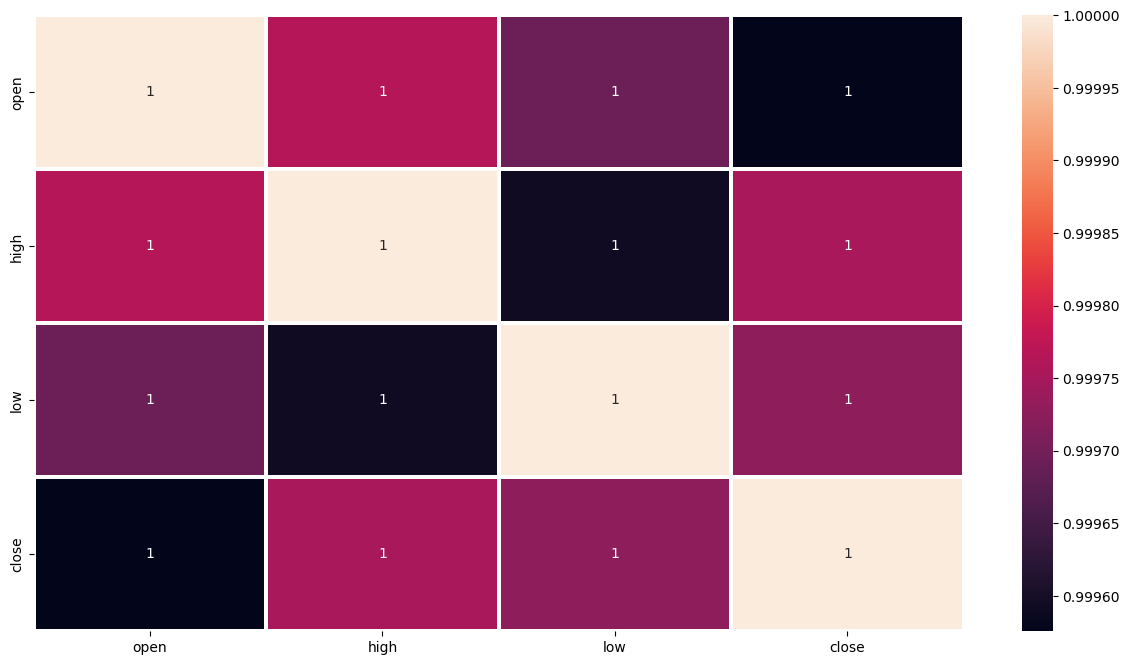

In [14]:
#importing ploting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
colors = ['#FF9900','#000000']
fig=plt.figure(figsize=(15,8))
sns.heatmap(nifty50.corr(), annot=True, linecolor='white', linewidth=2 )

In [15]:
nifty50.isnull().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

In [16]:
X = nifty50[['open', 'high','low']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature           VIF
0    open  43354.905677
1    high  32812.086381
2     low  25181.326456


In [17]:
X=nifty50[['open']]
y=nifty50['close']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test =scaler.transform(X_test)

In [20]:
nifty50.isnull().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

In [21]:
# Monthwise Comparision 
monthvise= nifty50.groupby(nifty50['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise.head()

open         close
date                                
March     11017.780793  11010.740244
May       11036.555357  11027.568750
April     11141.250662  11139.049669
January   11263.620588  11253.977941
February  11265.621656  11261.642038

In [22]:
nifty50.groupby(nifty50['date'].dt.strftime('%B'))['low'].min()

date
April        7516.85
August       7667.25
December     7551.05
February     6825.80
January      7241.50
July         8287.55
June         7927.05
March        7035.10
May          7678.35
November     7714.15
October      7930.65
September    7539.50
Name: low, dtype: float64

In [23]:
monthvise_high= nifty50.groupby(nifty50['date'].dt.strftime('%B'))['high'].max()
monthvise_low= nifty50.groupby(nifty50['date'].dt.strftime('%B'))['low'].min()

In [24]:
monthvise_high

date
April        18114.65
August       17992.20
December     17639.50
February     17794.60
January      18350.95
July         17172.80
June         16793.85
March        17559.80
May          17132.85
November     18210.15
October      18604.45
September    18096.15
Name: high, dtype: float64

In [25]:
monthvise_low

date
April        7516.85
August       7667.25
December     7551.05
February     6825.80
January      7241.50
July         8287.55
June         7927.05
March        7035.10
May          7678.35
November     7714.15
October      7930.65
September    7539.50
Name: low, dtype: float64

In [26]:
# Dataset creation 
closedf_nifty = nifty50[['date','close']]
print("Shape of close dataframe:", closedf_nifty.shape)

Shape of close dataframe: (1917, 2)


In [27]:
# Normalizing / scaling close value between 0 to 1
close_stock = closedf_nifty.copy()
del closedf_nifty['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf_nifty=scaler.fit_transform(np.array(closedf_nifty).reshape(-1,1))
print(closedf_nifty.shape)

(1917, 1)


In [28]:
# Split test train 
training_size=int(len(closedf_nifty)*0.65)
test_size=len(closedf_nifty)-training_size
train_data,test_data=closedf_nifty[0:training_size,:],closedf_nifty[training_size:len(closedf_nifty),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1246, 1)
test_data:  (671, 1)


In [29]:
# Create new dataset according to requirement of time-series prediction

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1230, 15)
y_train:  (1230,)
X_test:  (655, 15)
y_test (655,)


# Algorithms 

# LSTM

In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1230, 15, 1)
X_test:  (655, 15, 1)


In [32]:
time_step

15

In [33]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [34]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_percentage_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_percentage_error(original_ytest,test_predict))

NameError: name 'original_ytrain' is not defined

In [61]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [62]:
test_mape = mean_absolute_percentage_error(original_ytest, test_predict)
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict)

NameError: name 'original_ytest' is not defined

In [39]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9962720046472994
Test data explained variance regression score: 0.9538707416561529


In [40]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9962680551988417
Test data R2 score: 0.8989215011900372


In [41]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  8.389477241434584e-05
Test data MGD:  0.0031899083312772083
----------------------------------------------------------------------
Train data MPD:  0.7819792032753637
Test data MPD:  51.08059163932285


In [42]:
# shift train predictions for plotting
from itertools import cycle

look_back=time_step
trainPredictPlot = np.empty_like(closedf_nifty)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf_nifty)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf_nifty)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1917, 1)
Test predicted data:  (1917, 1)


In [43]:
# predicting next 10 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [44]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [45]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf_nifty[len(closedf_nifty)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [46]:
lstmdf=closedf_nifty.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

# GRU

In [47]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1230, 15, 1)
X_test:  (655, 15, 1)


In [48]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(121,return_sequences=True))
model.add(GRU(121,return_sequences=True))
model.add(GRU(121))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 121)           56265     
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 121)           88572     
_________________________________________________________________
gru_3 (GRU)                  (None, 121)               88572     
_________________________________________________________________
dense (Dense)                (None, 1)                 122       
Total params: 236,891
Trainable params: 236,891
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
246/246 [==============================] - 15s 42ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2/200
246/246 [==============================] - 10s 39ms/step - loss: 3.3294e-04 - val_loss: 6.7566e-04
Epoch 3/200
246/246 [==============================] - 12s 51ms/step - loss: 1.9458e-04 - val_loss: 0.0033
Epoch 4/200
246/246 [==============================] - 9s 37ms/step - loss: 2.3831e-04 - val_loss: 3.5221e-04
Epoch 5/200
246/246 [==============================] - 8s 33ms/step - loss: 1.3086e-04 - val_loss: 7.6171e-04
Epoch 6/200
246/246 [==============================] - 7s 28ms/step - loss: 1.1310e-04 - val_loss: 2.8010e-04
Epoch 7/200
246/246 [==============================] - 7s 27ms/step - loss: 8.8720e-05 - val_loss: 7.6309e-04
Epoch 8/200
246/246 [==============================] - 6s 23ms/step - loss: 8.7870e-05 - val_loss: 6.3904e-04
Epoch 9/200
246/246 [==============================] - 6s 24ms/step - loss: 1.3276e-04 - val_loss: 2.8902e-04
Epoch 10/200
246/24

Epoch 152/200
246/246 [==============================] - 11s 45ms/step - loss: 9.1583e-05 - val_loss: 0.0164
Epoch 153/200
246/246 [==============================] - 8s 34ms/step - loss: 7.6079e-05 - val_loss: 0.0158
Epoch 154/200
246/246 [==============================] - 8s 34ms/step - loss: 6.9327e-05 - val_loss: 0.0128
Epoch 155/200
246/246 [==============================] - 10s 39ms/step - loss: 8.5984e-05 - val_loss: 0.0132
Epoch 156/200
246/246 [==============================] - 10s 40ms/step - loss: 7.4005e-05 - val_loss: 0.0137
Epoch 157/200
246/246 [==============================] - 10s 41ms/step - loss: 7.6265e-05 - val_loss: 0.0160
Epoch 158/200
246/246 [==============================] - 10s 42ms/step - loss: 6.9009e-05 - val_loss: 0.0156
Epoch 159/200
246/246 [==============================] - 9s 37ms/step - loss: 7.4540e-05 - val_loss: 0.0169
Epoch 160/200
246/246 [==============================] - 11s 43ms/step - loss: 6.2644e-05 - val_loss: 0.0153
Epoch 161/200
246/246 

In [53]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((1230, 1), (655, 1))

In [56]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [57]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  111741936.01204227
Train data MSE:  1.2486260263719348e+16
Test data MAE:  110562703.52235772
-------------------------------------------------------------------------------------
Test data RMSE:  153761972.39429492
Test data MSE:  2.3642744154583916e+16
Test data MAE:  152276725.02076334


In [57]:
print("Test data Mape: ",mean_absolute_percentage_error(original_ytest,test_predict))
print("Train data Mape: ",mean_absolute_percentage_error(original_ytrain,train_predict))

NameError: name 'mean_absolute_percentage_error' is not defined

In [58]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: -131015051.05137616
Test data explained variance regression score: -55602853.1674858


In [59]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: -6240302087.857242
Test data R2 score: -2892143446.9102006


In [60]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  16.68755143220626
Test data MGD:  16.526222935658332
----------------------------------------------------------------------
Train data MPD:  220944576.883633
Test data MPD:  304283360.99992955


In [64]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf_nifty)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf_nifty)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf_nifty)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)


names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1917, 1)
Test predicted data:  (1917, 1)


#  ARIMA

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

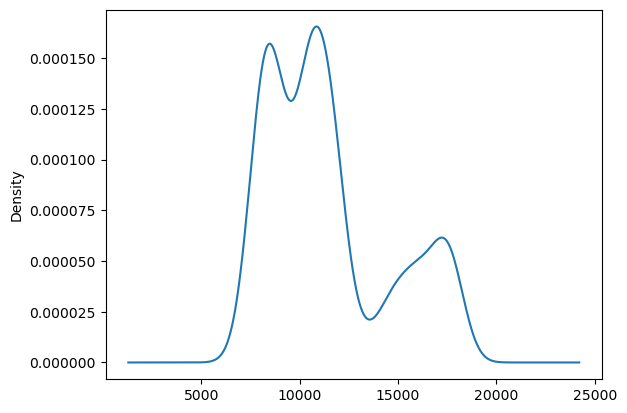

In [25]:
#Distribution of the dataset
df_close = nifty50['close']
df_close.plot(kind='kde')

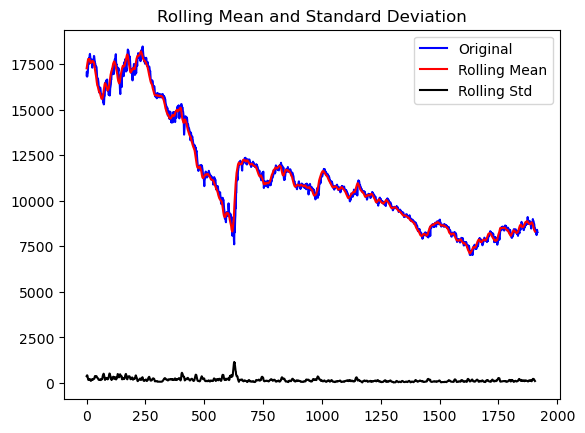

Results of dickey fuller test
Test Statistics                  -0.358175
p-value                           0.916851
No. of lags used                  6.000000
Number of observations used    1910.000000
critical value (1%)              -3.433778
critical value (5%)              -2.863054
critical value (10%)             -2.567576
dtype: float64


In [26]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

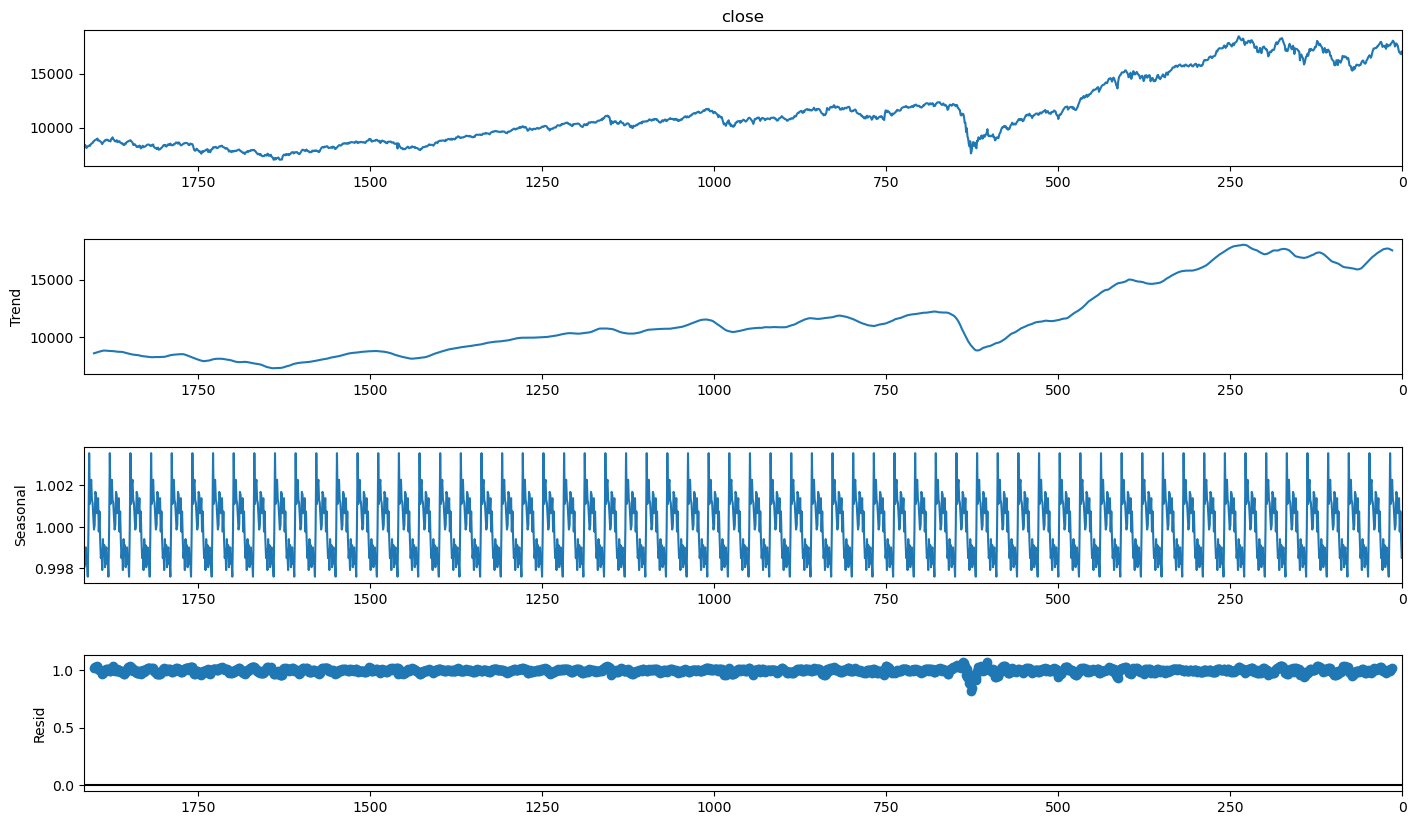

In [27]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


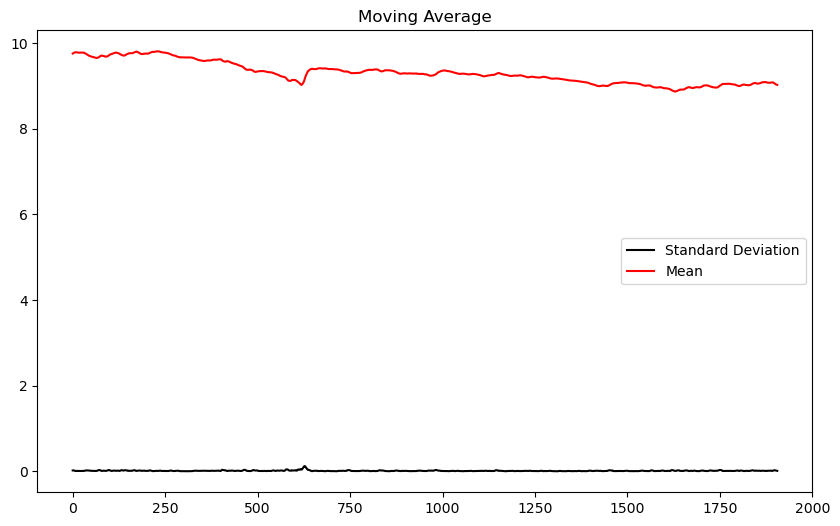

In [28]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

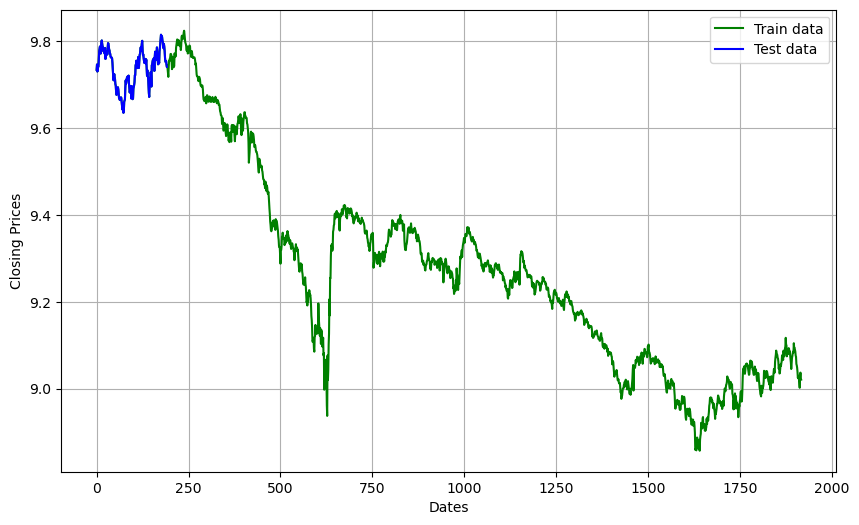

In [29]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

#  Auto Arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10493.309, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10499.396, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10499.058, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10493.029, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10497.931, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10497.692, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10495.980, Time=0.84 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10498.776, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.371 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1722
Model:               SARIMAX(1, 1, 0)   Log Likelihood                5252.698
Date:                Fri, 14 Oct 2022   AIC                         -10499.396
Time:               

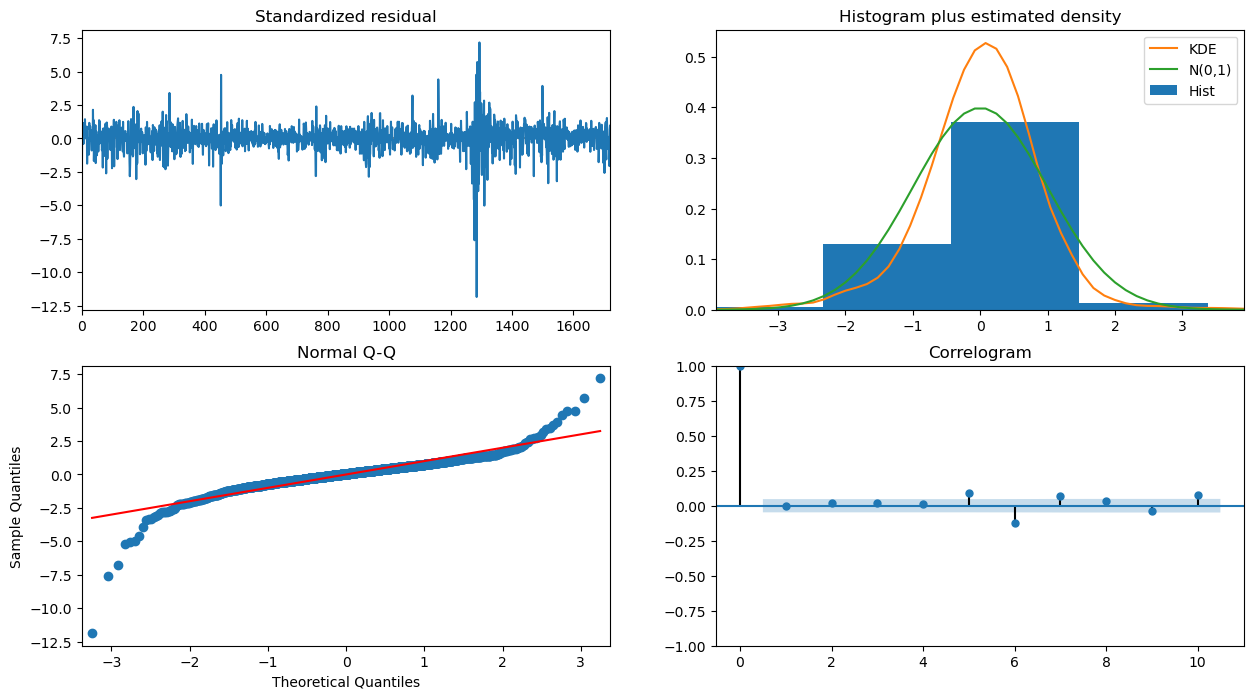

In [30]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [31]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1722
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5251.770
Date:                Fri, 14 Oct 2022   AIC                         -10495.541
Time:                        11:15:50   BIC                         -10473.738
Sample:                             0   HQIC                        -10487.474
                               - 1722                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0331      0.471     -0.070      0.944      -0.957       0.891
ma.L1         -0.0334      0.469     -0.071      0.943      -0.953       0.886
ma.L2          0.0226      0.034      0.670      0.5

In [52]:
fitted.forecast(321, alpha=0.05)

C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


1722    9.745026
1723    9.745202
1724    9.745196
1725    9.745196
1726    9.745196
          ...   
2038    9.745196
2039    9.745196
2040    9.745196
2041    9.745196
2042    9.745196
Name: predicted_mean, Length: 321, dtype: float64

In [55]:
# Forecast
*fc = fitted.forecast(321, alpha=0.05)  # 95% conf

SyntaxError: starred assignment target must be in a list or tuple (2193684944.py, line 5)

In [54]:
fc,  conf = fitted.forecast(321, alpha=0.05)

C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


ValueError: too many values to unpack (expected 2)

# FBProphet

In [36]:
# # Select only the important features i.e. the date and price
data = nifty50[["date","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data.rename(columns = {"date":"ds","close":"y"},inplace=True) #renaming the columns of the dataset
#data.columns = ['TEST', 'ODI', 'T-20']
data.head(2)

C:\Users\Joshika\Anaconda3\envs\sp\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


ds       y
1916 2015-01-01  8272.8
1915 2015-01-02  8288.7

In [45]:
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

In [46]:
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1534, 2)
testing data size : (383, 2)


In [48]:
y_actual, y_predicted

(1905     8504.05
 1893     8789.15
 1892     8733.10
 1891     8696.85
 1888     8603.30
           ...   
 33      17825.25
 30      17758.45
 19      17655.60
 9       17816.25
 5       17016.30
 Name: y, Length: 383, dtype: float64,
 0        9028
 1        9006
 2        9027
 3        9043
 4        9041
         ...  
 2277    19043
 2278    19491
 2279    18945
 2280    19055
 2281    19070
 Name: yhat, Length: 2282, dtype: int32)

In [47]:
model = Prophet(daily_seasonality=True)
model.fit(train_data)
y_actual = test_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)
prediction = model.predict(pd.DataFrame({'ds':test_data['ds']}))

11:26:25 - cmdstanpy - INFO - Chain [1] start processing
11:26:25 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [383, 2282]

In [37]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

11:16:44 - cmdstanpy - INFO - Chain [1] start processing
11:16:46 - cmdstanpy - INFO - Chain [1] done processing


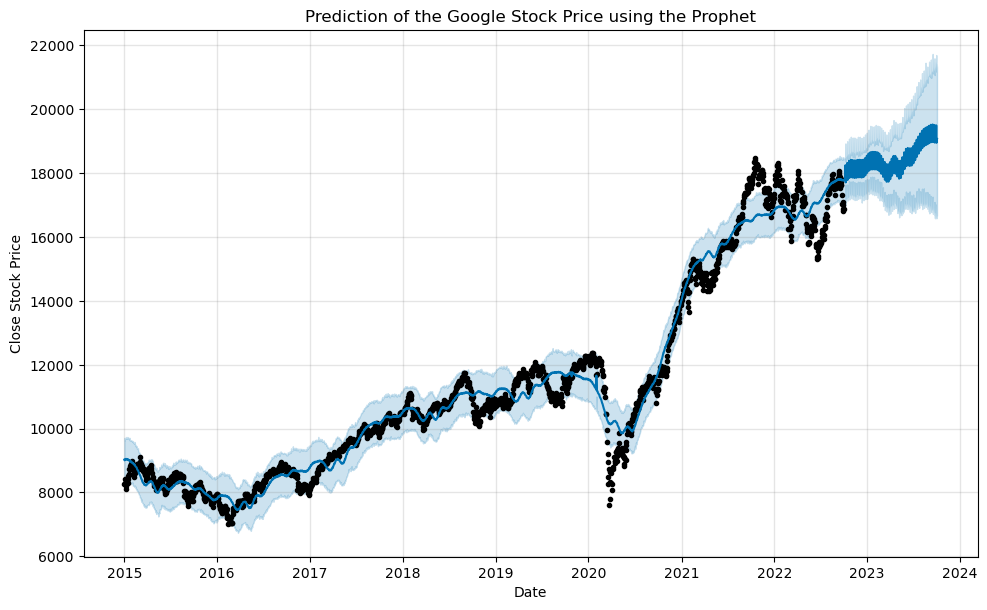

In [38]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

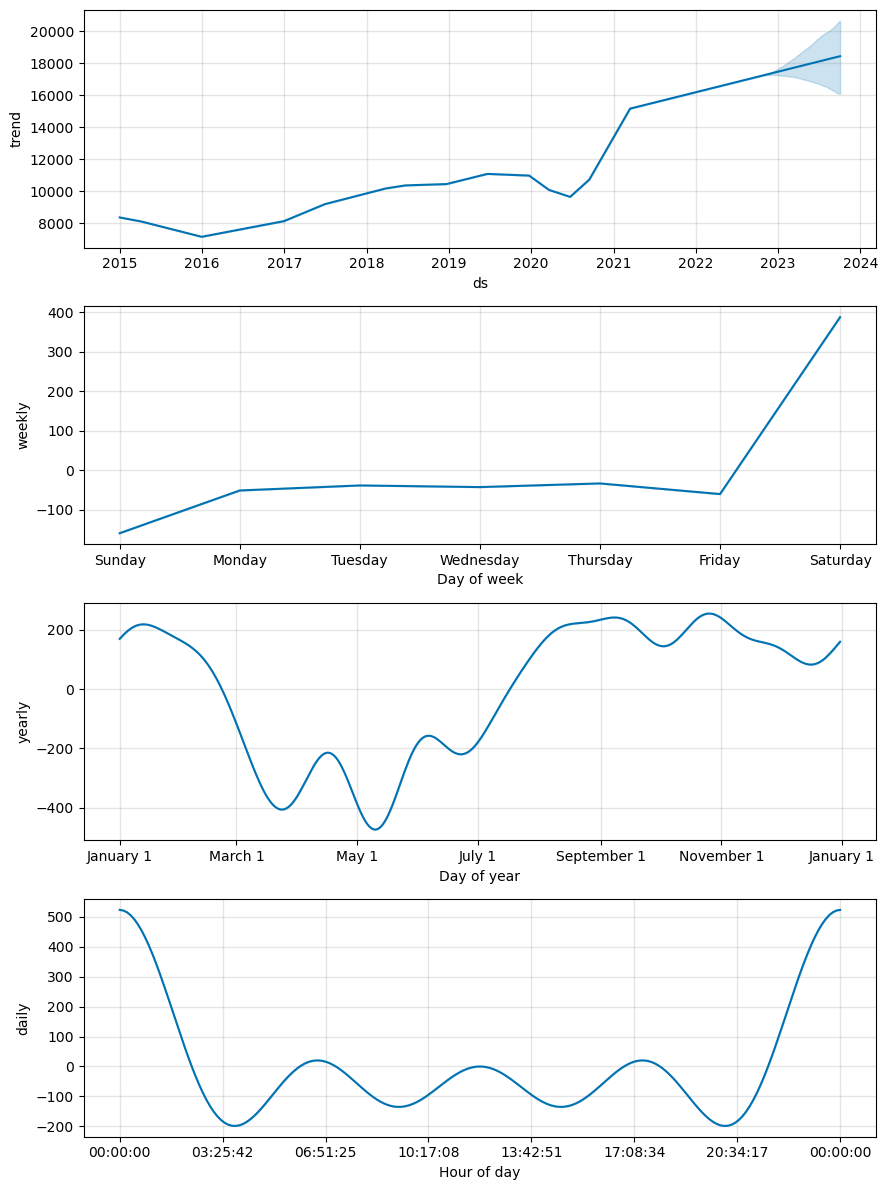

In [39]:
m.plot_components(prediction)
plt.show()

In [40]:
prediction

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0    2015-01-01   8372.579575   8347.054436   9708.201232   8372.579575   
1    2015-01-02   8370.013770   8314.553138   9627.888960   8370.013770   
2    2015-01-05   8362.316356   8411.210828   9705.640994   8362.316356   
3    2015-01-06   8359.750552   8400.197438   9682.110890   8359.750552   
4    2015-01-07   8357.184747   8378.034073   9706.000526   8357.184747   
...         ...           ...           ...           ...           ...   
2277 2023-09-29  18426.984904  16616.197644  21261.290568  16116.697630   
2278 2023-09-30  18430.497416  17013.236265  21693.057289  16113.123875   
2279 2023-10-01  18434.009927  16583.151916  21173.547133  16109.115376   
2280 2023-10-02  18437.522439  16652.719677  21400.243160  16101.245512   
2281 2023-10-03  18441.034951  16669.016811  21309.994056  16092.311059   

       trend_upper  additive_terms  additive_terms_lower  \
0      8372.579575      655.840117            655.840117   
1      8370.013770      636.411663            636.411663   
2      8362.316356      665.593180            665.593180   
3      8359.750552      683.955275            683.955275   
4      8357.184747      684.775837            684.775837   
...            ...             ...                   ...   
2277  20620.364968      616.348219            616.348219   
2278  20627.544756     1061.352025           1061.352025   
2279  20634.724545      511.070816            511.070816   
2280  20641.904334      617.705091            617.705091   
2281  20651.544323      629.724552            629.724552   

      additive_terms_upper       daily  ...      weekly  weekly_lower  \
0               655.840117  523.709071  ...  -33.752027    -33.752027   
1               636.411663  523.709071  ...  -60.687379    -60.687379   
2               665.593180  523.709071  ...  -51.589995    -51.589995   
3               683.955275  523.709071  ...  -38.837035    -38.837035   
4               684.775837  523.709071  ...  -42.976868    -42.976868   
...                    ...         ...  ...         ...           ...   
2277            616.348219  523.709071  ...  -60.687379    -60.687379   
2278           1061.352025  523.709071  ...  387.760830    387.760830   
2279            511.070816  523.709071  ... -159.917527   -159.917527   
2280            617.705091  523.709071  ...  -51.589995    -51.589995   
2281            629.724552  523.709071  ...  -38.837035    -38.837035   

      weekly_upper      yearly  yearly_lower  yearly_upper  \
0       -33.752027  165.883073    165.883073    165.883073   
1       -60.687379  173.389971    173.389971    173.389971   
2       -51.589995  193.474105    193.474105    193.474105   
3       -38.837035  199.083239    199.083239    199.083239   
4       -42.976868  204.043634    204.043634    204.043634   
...            ...         ...           ...           ...   
2277    -60.687379  153.326527    153.326527    153.326527   
2278    387.760830  149.882124    149.882124    149.882124   
2279   -159.917527  147.279273    147.279273    147.279273   
2280    -51.589995  145.586015    145.586015    145.586015   
2281    -38.837035  144.852516    144.852516    144.852516   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
2277                   0.0                         0.0   
2278                   0.0                         0.0   
2279                   0.0                         0.0   
2280                   0.0                         0.0   
2281                   0.0                         0.0   

      multiplicative_terms_upper          yhat  
0                      

In [41]:
y_actual.shape

(1917,)

In [44]:
model = Prophet(daily_seasonality=True)
model.fit(train_data)
y_actual = test_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)
prediction = model.predict(pd.DataFrame({'ds':test_data['ds']}))

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.